# A very quick demonstration of using the fastai library

- This Jupyter worksheet will show how to create a couple of models that identify digits from the MNIST data set of hand written digits.
  - How to load the data and get it into a form that fastai code can use.
  - How to fine-tune an existing trained model to categorize the MNIST digits.
  - How to construct and train a very simple model from scratch to categorize
    the MNIST digits.
- I will discuss some useful resources
  - Training data repositories
  - Model repositories
  - The fast.ai course (Parts 1 and 2)


# What is fast.ai?

Fast.ai is a non-profit research group focused on deep learning and artificial intelligence. They want to make deep learning as accessible as possible.

They have an on-line course ["Practical Deep Learning for Coders"](https://course.fast.ai/).

The fastai library is built on top of PyTorch which aims to make it easy to create and apply deep learning models to problems. A lot of functionality is provided by default but can be overridden as required.

# How to run this notebook

This is a [Jupyter](https://jupyter.org/) notebook. Jupyter notebooks are a combination of test and runnable Python code, and are commonly used in the machine learning community.

There is an introduction to Jupyter notebooks on [Kaggle](https://www.kaggle.com/code/jhoward/jupyter-notebook-101).

You can run Jupyter notebooks locally, if you install the required software, using your own CPU and GPU.

Alternatively (and more easily), you can run Jupyter notebooks in a number of environments with support for machine learning:

- [Kaggle](https://www.kaggle.com/)
- [Paperspace Gradient](https://docs.paperspace.com/gradient/notebooks)
- [Google CoLab](https://colab.research.google.com/)

I have been using CoLab, which provides access to lower level GPUs for free (though there is a limited pool of them), or you can pay for access to faster GPUs.

TODO Put on GitHub and share to Scott Logic. Make sure it can be opened in CoLab.

# Get the libraries we need

In [ ]:
# Install the libraries we need
!pip install -Uqq fastai
!pip install -Uqq datasets  # Huggingface datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.9 MB/s eta 0:00:00


In [ ]:
# Import what we need
from datasets import load_dataset,load_dataset_builder
from fastai.data.all import *
from fastai.vision.all import *

# Load the MNIST data set and get it ready for use

The MNIST data set is a labelled set of 70,000 hand written digits. We will load it from the Hugging Face repo, [here](https://huggingface.co/datasets/mnist).

Classifying the MNIST data set was a common target of machine learning research. It is probably not so interesting now as it is a fairly simple problem.

First we will get an idea of what is in the dataset.

In [ ]:
# Load a dataset builder, and get the description of the dataset.
ds_builder = load_dataset_builder('mnist')
print(ds_builder.info.description)

The MNIST dataset consists of 70,000 28x28 black-and-white images in 10 classes (one for each digits), with 7,000
images per class. There are 60,000 training images and 10,000 test images.



Each item in the dataset consists of an image and a label.

In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

The dataset builder just retrieved metadata about the MNIST dataset. Now we will actually load the dataset.

In [ ]:
mnist_dsd = load_dataset('mnist')

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

The data is split into train and test datasets.

In [ ]:
mnist_dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

If we look at the first item in the training dataset we can see it consists of a dictionary containing a PNG image and the label `5`.

In [ ]:
mnist_dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

We need to get the Hugging Face training dataset into a form that the fastai code understands. To do this we create a `DataBlock`, which specifies how to get each item from the dataset and how to split it into the x (input) and y (target) values.





In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),              # Specify what kind of things the inputs and targets are
                   get_items = lambda ds: ds,                            # Don't need to do anything to the items in the dataset list
                   get_x     = lambda item: item['image'],               # Get the input value using the 'image' key
                   get_y     = lambda item: f"{item['label']}",          # Get the target value using the 'label' key
                   splitter  = RandomSplitter(valid_pct=0.2, seed=42),   # Randomly split into 80% training data, 20% validation data. Specify the seed to make it reproducible.
                   item_tfms = Resize(224)                               # Resize the images to 224x224 to match the resnet18 input size
                   )

The images will be resized from 28x28 to 224x224, which is the size that the `resnet18` model expects. The resizing will use the default interpolation mode (`BILINEAR`), but we could have specified one to use. The pipeline will also convert the PNG images to tensors for us.

It is also possible to use a `batch_tfms` parameter to specify a transform to apply when a batch is fetched, to randomly rotate, flip, crop or shift images, so that slightly different versions of the image are used in each training epoch. This can improve performance on previously unseen data. I am not doing this here.

In [ ]:
# Uncomment and run the summary method if you want to know more about the pipeline the DataBlock will run
dblock.summary(mnist_dsd['train'])

Setting-up type transforms pipelines
    features: ['image', 'label'],
    num_rows: 60000
})
Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      {'image': PILImage mode=L size=28x28, 'label': 6}
    applying <lambda> gives
      PILImage mode=L size=28x28
    applying PILBase.create gives
      PILImage mode=L size=28x28
  Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      {'image': PILImage mode=L size=28x28, 'label': 6}
    applying <lambda> gives
      6
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=L size=28x28, TensorCategory(6))


    features: ['image', 'label'],
    num_rows: 60000
})
Found 60000 items
2 datasets of

Use the `DataBlock` to load the training dataset into a `DataLoaders` object.

In [ ]:
mnist_dls = dblock.dataloaders(mnist_dsd['train'])

The `DataLoaders` object now contains a training dataloader and a validation dataloader.

In [ ]:
mnist_dls.train.bs, mnist_dls.valid.bs

(64, 64)



The training and validation data has batch sizes of 64. This is the default. We could have specified it when we created the dataloaders, but 64 is fine.

A batch will be processed in one set of matrix operations by the GPU. The larger the batch, the quicker training will run, but if the batch size is too large then the GPU will run out of memory.

Show some items from a training batch.

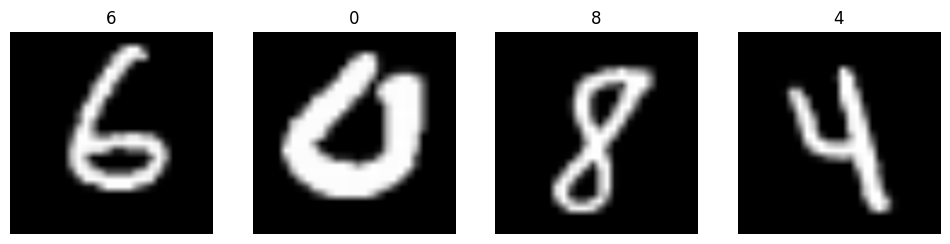

In [ ]:
mnist_dls.train.show_batch(max_n=4, nrows=1, cmap='gray')

And from a validation batch.

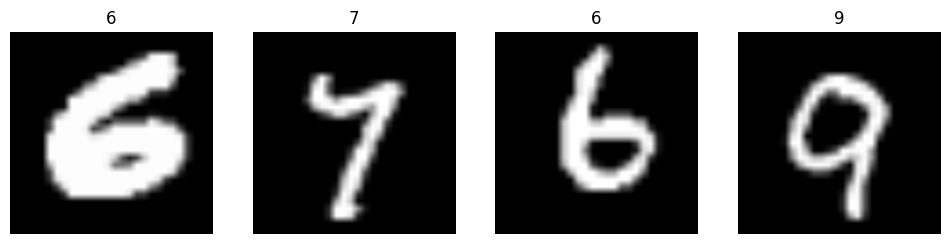

In [ ]:
mnist_dls.valid.show_batch(max_n=4, nrows=1, cmap='gray')

# Fine-tune a ResNet-18 model

ResNet-18 is an 18 layer [convolutional neural network](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/).

Residual networks use "residual connections" which sum the output of one layer with the input of that layer or an earlier layer (a skip connection). These have been found to help with training.

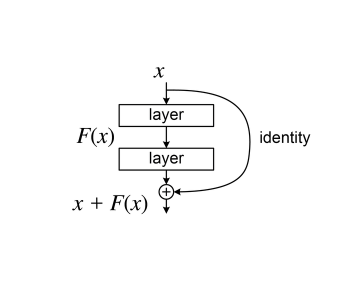

*(Image is from Wikipedia, author LunarLullaby, CC BY-SA 4.0 license declaration [here](https://en.wikipedia.org/wiki/File:ResBlock.png))*


ResNets of various sizes are a popular choice for image classification tasks.

A `Learner` for vision processing is created by calling `vision_learner` and passing in our mnist dataloaders and the `resnet18` pretrained model from PyTorch. A number of [models](https://pytorch.org/vision/stable/models.html#classification) are available from PyTorch, including [ResNet models](https://pytorch.org/vision/stable/models/resnet.html).

## Download and fine-tune a ResNet-18 model

The Learner is created from

- `mnist_dls` - the dataloaders containing our training and validation data.
- `resnet18` - a pretrained Resnet-18 model from PyTorch.
- `metrics=error_rate` - we use the error rate as our metric (compare the digit with the highest probability in our output with the target digit).
- `cbs=ShowGraphCallback()` - use a callback to display a progress graph during training.

The optimization function defaults to the [Adam](https://docs.fast.ai/optimizer.html#adam-1) optimizer, which uses momentum and adaptive learning rates to improve on the traditional stochastic gradient descent algorithm. See
[here](https://www.aiplusinfo.com/blog/what-is-the-adam-optimizer-and-how-is-it-used-in-machine-learning/) for a discussion of Adam..

The loss function defaults to [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which is an appropriate loss function to use here.

In [ ]:
learn = vision_learner(mnist_dls, resnet18, metrics=error_rate, cbs=ShowGraphCallback())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

epoch,train_loss,valid_loss,error_rate,time
0,0.159146,0.088132,0.026750,01:55


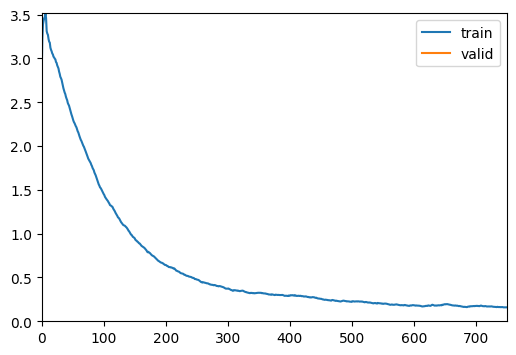

epoch,train_loss,valid_loss,error_rate,time
0,0.049700,0.031873,0.010417,01:58
1,0.045623,0.034655,0.009833,01:54
2,0.034744,0.020515,0.005667,01:54
3,0.033462,0.024240,0.006750,01:56
4,0.017062,0.027059,0.006667,01:54
5,0.012193,0.024833,0.005500,01:56
6,0.003959,0.024303,0.004750,01:54
7,0.001102,0.018462,0.003250,01:57
8,0.000694,0.017740,0.003583,01:54
9,0.000333,0.018436,0.003500,01:52


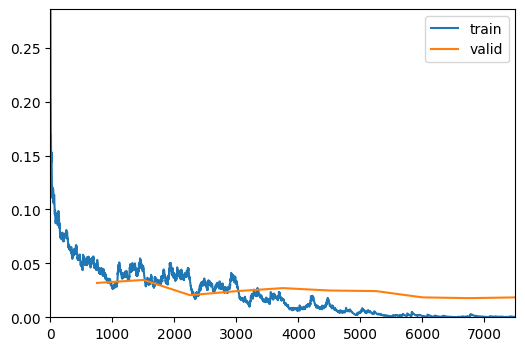

In [ ]:
learn.fine_tune(3)

## Take a look at the errors

`ClassificationInterpretation` is a tool for examining the output of a classification learner.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Taking a look at the confusion matrix, the most frequent confusions are what we would expect; `5` identified as `3`, `9` identified as `6` or `4`, `7` identified as `1` or `2`.

Note: On different runs through training the model has had different confusions.

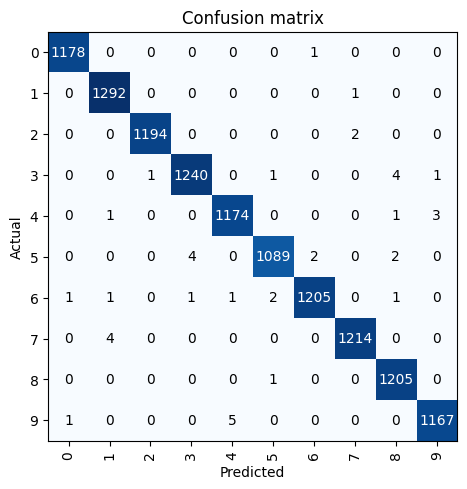

In [ ]:
interp.plot_confusion_matrix()

Looking at the worst misses, they either seem to be mislabelled or they are unrecognizable as a digit.

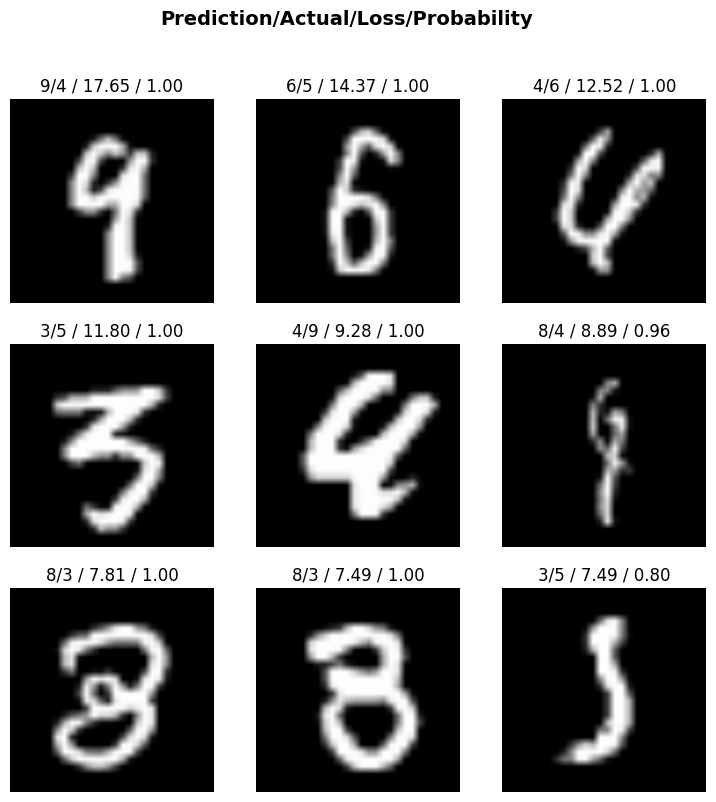

In [ ]:
interp.plot_top_losses(k = 9)

## Check the accuracy on the test data set

Create a dataloader for the test data set.

In [ ]:
mnist_test_dl = mnist_dls.test_dl(mnist_dsd['train'], with_labels=True)

Show the first few items in the test dataloader.

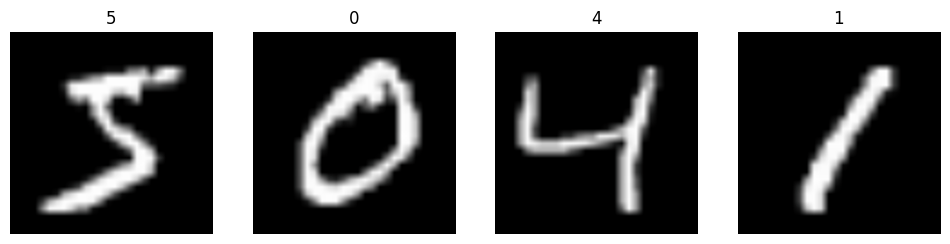

In [ ]:
mnist_test_dl.show_batch(max_n=4, nrows=1, cmap='gray')

Get predictions for the test data set from the model.

In [ ]:
preds, targs = learn.get_preds(dl=mnist_test_dl)

Let's look at the first prediction and target.

tensor([3.6044e-08, 2.7017e-08, 1.3026e-08, 2.1846e-04, 1.1135e-07, 9.9978e-01,
        7.4944e-08, 2.2176e-06, 2.0654e-06, 8.1869e-07]) tensor(5)


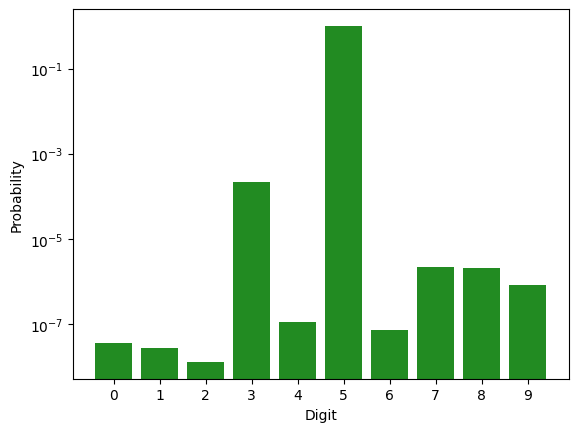

In [ ]:
print(preds[0], targs[0])

import matplotlib.pyplot as plt
labels = [f"{n}" for n in range(preds[0].size(dim=0))]
plt.bar(labels, preds[0].tolist(), align='center', color=['forestgreen'], log=True)
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.show()

You can see that the item with the highest probability is at index 5, which matches the target value of '5'.

The next highest probabilities are for '3' and '8', which makes sense. They are much smaller though (< 0.001), which is why I used a log scale for the y-axis.

Computing the overall accuracy, it is pretty good. Maybe better than the validation set accuracy. Perhaps the test set was checked over more thoroughly?

In [ ]:
error_rate(preds, targs)

TensorBase(0.0007)

# Creating a simple model from scratch

## Reload the data, with no resizing of the image

The previous DBlock resized the images so they matched what resnet-18 expected.

We don't want a 224x224 input size for our simple neural network.

We will load the data again, this time keeping the image size to 28x28.

In [ ]:
simple_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),       # Specify what kind of things the inputs and targets are
                   get_items = lambda ds: ds,                            # Don't need to do anything to the items in the dataset list
                   get_x     = lambda item: item['image'],               # Get the input value using the 'image' key
                   get_y     = lambda item: f"{item['label']}",          # Get the target value using the 'label' key
                   splitter  = RandomSplitter(valid_pct=0.2, seed=42)    # Randomly split into 80% training data, 20% validation data. Specify the seed to make it reproducible.
                   )

In [ ]:
simple_mnist_dls = simple_dblock.dataloaders(mnist_dsd['train'])

Let's check some items from a training batch.

In [ ]:
simple_mnist_dls.train.dataset

(#48000) [(PILImage mode=L size=28x28, TensorCategory(6)),(PILImage mode=L size=28x28, TensorCategory(1)),(PILImage mode=L size=28x28, TensorCategory(6)),(PILImage mode=L size=28x28, TensorCategory(9)),(PILImage mode=L size=28x28, TensorCategory(4)),(PILImage mode=L size=28x28, TensorCategory(2)),(PILImage mode=L size=28x28, TensorCategory(8)),(PILImage mode=L size=28x28, TensorCategory(4)),(PILImage mode=L size=28x28, TensorCategory(5)),(PILImage mode=L size=28x28, TensorCategory(7))...]

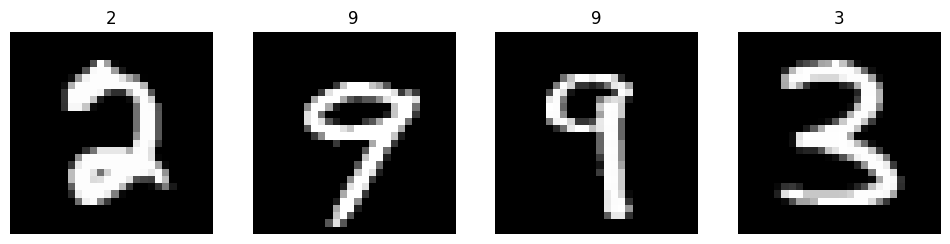

In [ ]:
simple_mnist_dls.train.show_batch(max_n=4, nrows=1, cmap='gray')

## Define a simple neural network

TODO describe the NN structure

If we check the input sizes, we see that the input data is a 28*28 tensor. The Linear layer is expecting a tensor with a single dimension, so we need to flatten it first.


In [ ]:
xb, yb = simple_mnist_dls.one_batch()
xb.shape, yb.shape, simple_mnist_dls.c

(torch.Size([64, 1, 28, 28]), torch.Size([64]), 10)

In [ ]:
simple_net = torch.nn.Sequential(
    Flatten(),
    torch.nn.Linear(28*28,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10)
  )

The Learner is created from

- `simple_mnist_dls` - the dataloaders containing our training and validation data.
- `simple_net` - our simple neural network model.
- `opt_func=Adam` - we use the [Adam](https://docs.fast.ai/optimizer.html#adam-1) optimiser, which uses momentum and adaptive learning rates to improve on the traditional stochastic gradient descent algorithm. See
[here](https://www.aiplusinfo.com/blog/what-is-the-adam-optimizer-and-how-is-it-used-in-machine-learning/) for a discussion of Adam.
- `metrics=error_rate` - we use the error rate as our metric (compare the digit with the highest probability in our output with the target digit).
- `cbs=ShowGraphCallback()` - use a callback to display a graph during training.

The loss function defaults to [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which is an appropriate loss function to use here.

In [ ]:
simple_learn = Learner(simple_mnist_dls, simple_net, opt_func=Adam, metrics=error_rate, cbs=ShowGraphCallback())

Take a look at the summary of the Learner.

Note that the input and output shapes are `68 x ...` because our batch size is 64. The processing of the entire batch is bundled into one sequence of matrix operations, which can be efficiently run on a GPU.

In [ ]:
simple_learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 784            
Flatten                                                        
____________________________________________________________________________
                     64 x 100            
Linear                                    78500      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10             
Linear                                    1010       True      
ReLU                                                           
Linear                                    110        True      
____________________________________________________________________________

Total params: 79,620
Total trainable params: 79,620
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fa8a5cf1990>
Loss function: Fla

Run the learning rate finder tool to get a suitable starting learning rate.

Note that the Adam optimizer will adjust the learning rate per weight as the Learner is run.

SuggestedLRs(valley=0.00363078061491251)

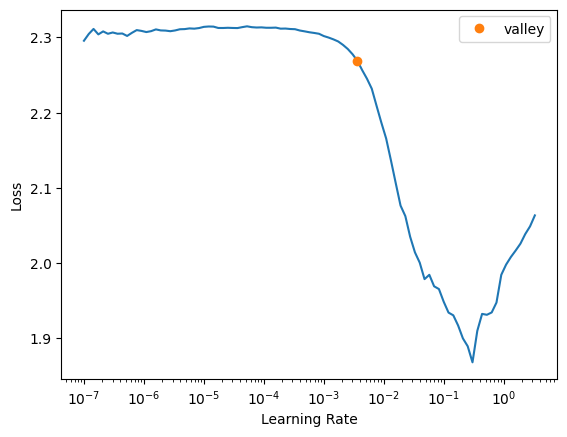

In [ ]:
simple_learn.lr_find()

In [ ]:
simple_learn.lr = 0.004

The model starts with a random set of weights, unlike the ResNet-18 model which was pretrained on a larger and more general purpose training set.

From experimentation, the validation loss didn't really improve after about 5 epochs.

epoch,train_loss,valid_loss,error_rate,time
0,0.227060,0.194347,0.057167,00:41
1,0.165903,0.153894,0.044667,00:41
2,0.116700,0.127656,0.035667,00:40
3,0.089137,0.113645,0.031750,00:40
4,0.088851,0.149872,0.043500,00:40


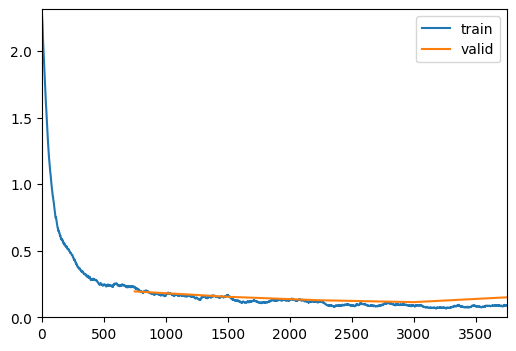

In [ ]:
simple_learn.fit(5)

So, the final error rate during training of our simple model was about 3%.

Training just the output layer of the pretrained ResNet-18 model gave an error of 2.7%, and training fully for three epochs gave a final training error of 0.5%.

## Check the accuracy on the test data set

Create a dataloader for the test data set.

In [ ]:
simple_mnist_test_dl = simple_mnist_dls.test_dl(mnist_dsd['train'], with_labels=True)

Get predictions for the test data set from the model.

In [ ]:
preds, targs = simple_learn.get_preds(dl=simple_mnist_test_dl)

In [ ]:
error_rate(preds, targs)

TensorBase(0.0308)

Error on the test set is about 1.9%, compared to about 0.13% for the ResNet-18 model.

Our simple model has 7,9620 trainable parameters (weights), whereas Resnet-18 has 18 layers of convolutions, 542,080 trainable parameters and 11,166,912 non-trainable parameters.

Note that by current standards, ResNet-18 is a very simple model.

State of the art on the MNIST classication task in 2020 was a 0.13% error rate, according to [Papers With Code](https://paperswithcode.com/sota/image-classification-on-mnist). That was with a CNN (convolutional neural network) model with 1,514,187 trainable parameters.





# Comments

## Building the demo

The hardest part of preparing this notebook was getting the loaded datasets into the `DataLoaders` object via a `DataBlock`. I hadn't seen any examples using HuggingFace data, and I hadn't taken in everything I needed about how to use `DataBlock`s in the previous examples I had worked through. Now I have been through the process I understand it better.

Creating the Resnet-18 example was straight-forward, until I got to the point of wanting to evaluate the test data. Again it took me some time to figure out how to get the test dataset into something I could run with the trained model.

My main issue with creating my own simple model was I hadn't realized how straight-forward it was. After defining the layers, I thought I had to do more to define the model. But no, all I needed to do was supply the layers to the `Learner` and specify the optimization function.

The fast.ai framework is built on top of PyTorch and many of the components it uses, such as the optimizers and metrics, are from PyTorch. This can make it harder when you are stuck as a web search will often give you PyTorch examples. You do see how PyTorch is much lower level and requires much more code.

## Suggestions

The fastai library makes it easy to experiment.

You could:

- Change how the digits are scaled up to 224x224 for the resnet-18 model.
- Add augmentation to the training data.
- Run for more epochs and see how the validation loss increases after a certain point, even though the training loss is still decreasing (a sign of overtraining).
- Change the simple network model
  - More layers
  - Fewer layers
  - Bigger or smaller layers
  - Convolutions - probably directly after the input

# Resources

## Data repositories

It is much easier to use existing data sets than to create your own, and it makes it easy to compare your results.

- [Fast.ai](https://docs.fast.ai/data.external.html#datasets)
- [Kaggle](https://www.kaggle.com/datasets)
- [Hugging Face](https://huggingface.co/datasets)
- [PyTorch](https://pytorch.org/vision/stable/datasets.html)

## Model repositories

- [PyTorch](https://pytorch.org/vision/main/models.html)
- [Hugging Face](https://huggingface.co/models)
- [Kaggle](https://www.kaggle.com/models)

## Competitions

- [Kaggle](https://www.kaggle.com/competitions)

# The fast.ai course

Fast.ai have a free course ["Practical Deep Learning for Coders"](https://course.fast.ai/).

The course consists of video lessons presented by Jeremy Howard, co-founder of fast.ai and veteran of several ML based companies. There are Jupyter notebooks for the lessons, which are available from GitHub, and also on CoLab and possibly in other environments which support Jupyter notebooks.

There is an emphasis on practical application and experimentation.

## Part 1

Part one of the course gives a high-level introduction to ML and deep-learning using neural networks, using the fastai library. It dives straight into gathering data and applying maching learning to solve practical problems.

- [Part 1 Introduction](https://course.fast.ai/Lessons/lesson1.html)
- [Notebooks on GitHub](https://github.com/fastai/course22)

## Part 2

Part two of the course dives deeper into details of implementation. It doesn't actually use the fastai library but instead builds up its own "miniai" library from scratch. The initial stages start with basics such as matrix multiplication, but once implemented switch to using the PyTorch implementations.

The course eventually builds the components needed to implement Stable Diffusion. Implementing the Stable Diffusion model covers most of the commonly used deep learning components.  

- [Part 2 Overview](https://course.fast.ai/Lessons/part2.html)
- [Notebooks on GitHub](https://github.com/fastai/course22p2)